In [1]:
import cobra
from cobra import Model, Reaction, Metabolite
import pandas as pd
import cplex
import optlang
import math
import json
import sys
import cProfile
from optlang.symbolics import Zero, add
import cobra.util.solver as sutil
from cobra.flux_analysis.parsimonious import pfba
from IPython.core.display import HTML
import cobrakbase
sys.path.append("/Users/chandhanavoleti/Documents/SULI/ModelSEEDpy/ModelSEEDpy") #replace
#import modelseedpy.fbapkg
from modelseedpy import ElementUptakePkg, SimpleThermoPkg, ReactionUsePkg, BilevelPkg, CommKineticPkg, KBaseMediaPkg

from collections import Counter
import numpy as np
from itertools import combinations
import networkx as nx

cobrakbase 0.2.7


In [2]:
# Parameters:
#      modelInfo: array [model id, workspace number]
#      mediaInfo: array [media id, workspace number]
#      kinetic coefficient: parameter for CommKineticPkg()
#      abundances: parameter for CommKineticPkg()
#      graph1: if 1, displays graph with nodes for species and edges labeled with the interaction fluxes
#      graph2: if 1, stores data with graphInfo array, can use to create plots

def communityFBA(modelInfo,mediaInfo,kinetic_coeff,abundances=None,graph1=None,graph2=None,graphInfo=None):
    
    # Constraints
    kbase_api = cobrakbase.KBaseAPI()
    model = kbase_api.get_from_ws(modelInfo[0],modelInfo[1])
    model.solver = 'optlang-cplex'

    #Applying uptake limit to total carbon uptake by model
    eup = ElementUptakePkg(model)
    eup.build_package({"C":60})
    #Applying constraints based on KBase media
    media = kbase_api.get_from_ws(mediaInfo[0],mediaInfo[1])
    kmp = KBaseMediaPkg(model)
    kmp.build_package(media)
    #Applying community model kinetic constraints
    ckp = CommKineticPkg(model)
    ckp.build_package(kinetic_coeff,abundances)
    
    # ----------------------------------------------------------------
    
    # FBA
    biomass_objective = model.problem.Objective(
        1 * model.reactions.bio1.flux_expression,
        direction='max')
    model.objective = biomass_objective
    
    sol=model.optimize()
    
    # ----------------------------------------------------------------
    
    # Compute exchanges
    exchanges = {}
    speciesNum = []
    external_metabolites = []
    for rxn in model.reactions:
        # obtain species
        ind = rxn.id.rfind('_')
        if (rxn.id[ind + 1] == 'c' or rxn.id[ind + 1] == 'p') and rxn.id[ind + 2: ] != '0':
            species = rxn.id[ind + 2: ]
            speciesNum.append(species)

            for metabolite in rxn.metabolites:
                if metabolite.compartment == "e0":
                    external_metabolites.append(metabolite.id)
                    rate = 0
                    flux = sol.fluxes[rxn.id]
                    if flux != 0:
                        rate += rxn.metabolites[metabolite]*flux
                    if rate != 0:
                        exchanges[(metabolite.id,species)] = rate

    speciesNum = np.unique(speciesNum) # array of species numbers (ex. ["1","2","3"])
    speciesNumLen = len(speciesNum) # number of species (ex. 3)
    
    # ----------------------------------------------------------------
    
    # Cross feeding
    cross_all = []
    for metabolite in external_metabolites:
        r_out = {x: r for (m, x), r in exchanges.items() if m == metabolite and r > 0}
        r_in = {x: -r for (m, x), r in exchanges.items() if m == metabolite and -r > 0}
        total_in = sum(r_in.values())
        total_out = sum(r_out.values())
        total = max(total_in, total_out)

        cross = [(o1, o2, metabolite, r1 * r2 / total) for o1, r1 in r_out.items() for o2, r2 in r_in.items()]
        cross_all.extend(cross) # array columns: [donor, receiver, compound, rate]

    production = [[0] * speciesNumLen for i in range(speciesNumLen)] 
    consumption = [[0] * speciesNumLen for i in range(speciesNumLen)]
    # format: production[donorSpecies][receivingSpecies], where donorSpecies and receivingSpecies are indices
    # for value in the matrix that signifies the flux produced by donorSpecies and consumed by receivingSpecies

    # access location that corresponds to donorSpecies and receivingSpecies interaction and add flux value
    for i in cross_all:
        if i[0] is not None and i[1] is not None:
            production[int(i[0])-1][int(i[1])-1] += i[3]
            consumption[int(i[1])-1][int(i[0])-1] += i[3]
            
    # ----------------------------------------------------------------
    
    # Graphing
    if graph1 == 1: 
        G=nx.Graph()
        for i in speciesNum:
            G.add_node(i)
        for k in combinations(speciesNum, 2):
            sp1 = int(k[0])-1
            sp2 = int(k[1])-1
            interaction_flux = production[sp1][sp2]
            G.add_edge(k[0],k[1],weight=interaction_flux)

        pos=nx.circular_layout(G)
        nx.draw_networkx(G,pos)
        labels = nx.get_edge_attributes(G,'weight')
        nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)
        
    elif graph2 == 1: 
        # format of graphInfo: [total community biomass, nutrient uptake flux, byproduct production flux, 
        # interaction fluxes (multiple values, if multiple interactions), total interaction flux]
        
        # total community biomass
        graphInfo.append(sol.objective_value)
        
        # nutrient uptake/byproduct production
        nutrient_uptake = 0
        byproduct_production = 0
        for i in model.medium:
            if sol.fluxes[i] > 0:
                nutrient_uptake += sol.fluxes[i]
            elif sol.fluxes[i] < 0:
                byproduct_production += sol.fluxes[i]
        graphInfo.append(nutrient_uptake)
        graphInfo.append(byproduct_production)
        
        # interaction between each species pair + total interaction flux
        total_interaction_flux = 0
        for k in combinations(speciesNum, 2):
            sp1 = int(k[0])-1
            sp2 = int(k[1])-1
            interaction_flux = production[sp1][sp2]
            graphInfo.append(interaction_flux)
            total_interaction_flux = total_interaction_flux + interaction_flux
        graphInfo.append(total_interaction_flux)  

# 2-member community model

In [3]:
# TWO-MEMBER ZAHMEETH COMMUNITY MODEL
modelInfo_2 = ["CMM_iAH991V2_iML1515.kb",40576]
mediaInfo_2 = ["Btheta_Ecoli_minimal_media",40576]
graphInfo1 = []
communityFBA(modelInfo_2,mediaInfo_2,2100,abundances={"1":0.5,"2":0.5},graph1=1,graphInfo=graphInfo1)

# Changing the kinetic coefficient

In [4]:
allGraphInfo_kp2 = []
for kinetic_coeff in range(1000,4000,300):
    graphInfo_kp2 = []
    communityFBA(modelInfo_2,mediaInfo_2,kinetic_coeff=kinetic_coeff,abundances={"1":0.5,"2":0.5},graph2=1,graphInfo=graphInfo_kp2)
    allGraphInfo_kp2.append([kinetic_coeff, graphInfo_kp2])

In [5]:
# Display all graphs together:
import matplotlib.pyplot as plt

figure, axis = plt.subplots(5, 1, sharex=True)
plt.title("Two-member community model")
plt.xlabel("Kinetic coefficient")
  
axis[0].plot([col[0] for col in allGraphInfo_kp2], [col[1][0] for col in allGraphInfo_kp2], 'o-')
axis[0].set_title("Total community biomass")

axis[1].plot([col[0] for col in allGraphInfo_kp2], [col[1][1] for col in allGraphInfo_kp2], 'o-')
axis[1].set_title("Nutrient Uptake Flux")

axis[2].plot([col[0] for col in allGraphInfo_kp2], [col[1][2] for col in allGraphInfo_kp2], 'o-')
axis[2].set_title("Byproduct Production Flux")

axis[3].plot([col[0] for col in allGraphInfo_kp2], [col[1][3] for col in allGraphInfo_kp2], 'o-')
axis[3].set_title("Interaction between each species pair (E.coli and B.theta)")

axis[4].plot([col[0] for col in allGraphInfo_kp2], [col[1][4] for col in allGraphInfo_kp2], 'o-')
axis[4].set_title("Total interaction flux")

plt.rcParams['figure.dpi'] = 100
plt.show()

In [6]:
# To display individual graphs:
import matplotlib.pyplot as plt2

colNum_kp2 = 0 # corresponds to columns in allGraphInfo_kinetic2 (total community biomass, nutrient uptake flux, etc.)
plt2.plot([col[0] for col in allGraphInfo_kp2], [col[1][colNum_kp2] for col in allGraphInfo_kp2], 'o-')
plt2.title("Two-member community model: total interaction flux") # change title accordingly
plt2.xlabel("Kinetic coefficient")
plt2.show()

# Changing the species abundances

In [7]:
allGraphInfo_sa2 = []
for abundance1 in np.arange(0.1,1.0,0.2):
    graphInfo_sa2 = []
    abundance2 = 1.0 - abundance1
    communityFBA(modelInfo_2,mediaInfo_2,kinetic_coeff=2100,abundances={"1":abundance1,"2":abundance2},graph2=1,graphInfo=graphInfo_sa2)
    allGraphInfo_sa2.append([abundance1, graphInfo_sa2])

In [8]:
# To display all graphs together:
import matplotlib.pyplot as plt3

figure3, axis3 = plt3.subplots(5, 1, sharex=True)
plt3.title("Two-member community model")
plt3.xlabel("Species abundance")
plt3.xticks(np.arange(5), ['{E.coli:0.1,\nB.theta:0.9}', '{E.coli:0.3,\nB.theta:0.7}', '{E.coli:0.5,\nB.theta:0.5}', '{E.coli:0.7,\nB.theta:0.3}', '{E.coli:0.9,\nB.theta:0.1}'])  
  
axis3[0].plot([col[0] for col in allGraphInfo_sa2], [col[1][0] for col in allGraphInfo_sa2], 'o-')
axis3[0].set_title("Total community biomass")

axis3[1].plot([col[0] for col in allGraphInfo_sa2], [col[1][1] for col in allGraphInfo_sa2], 'o-')
axis3[1].set_title("Nutrient Uptake Flux")

axis3[2].plot([col[0] for col in allGraphInfo_sa2], [col[1][2] for col in allGraphInfo_sa2], 'o-')
axis3[2].set_title("Byproduct Production Flux")

axis3[3].plot([col[0] for col in allGraphInfo_sa2], [col[1][3] for col in allGraphInfo_sa2], 'o-')
axis3[3].set_title("Interaction between each species pair (species 1 and 2)")

axis3[4].plot([col[0] for col in allGraphInfo_sa2], [col[1][4] for col in allGraphInfo_sa2], 'o-')
axis3[4].set_title("Total interaction flux")

plt3.rcParams['figure.dpi'] = 100
plt3.show()

In [9]:
# To display individual graphs:
import matplotlib.pyplot as plt4

colNum_sa2 = 0
plt4.plot([i for i in list(range(5))], [col[1][colNum_sa2] for col in allGraphInfo_sa2], 'o-')
plt4.title("Total community biomass")
plt4.xlabel("Relative abundance")
plt4.xticks(np.arange(5), ['{E.coli:0.1,\nB.theta:0.9}', '{E.coli:0.3,\nB.theta:0.7}', '{E.coli:0.5,\nB.theta:0.5}', '{E.coli:0.7,\nB.theta:0.3}', '{E.coli:0.9,\nB.theta:0.1}'])  
plt4.show()

# 3-member community model

1:bio2
2:bio3
3:bio4


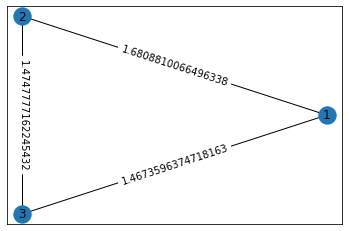

In [10]:
modelInfo_3 = ["electro.community.edited.v2",93204]
mediaInfo_3 = ["CO2_minimal",93204]
graphInfo2 = []
communityFBA(modelInfo_3,mediaInfo_3,2100,graph1=1,graphInfo=graphInfo2)

# Changing the kinetic coefficients

In [11]:
allGraphInfo_kp3 = []
for kinetic_coeff in range(1000,4000,300):
    graphInfo_kp3 = []
    communityFBA(modelInfo_3,mediaInfo_3,kinetic_coeff=kinetic_coeff,graph2=1,graphInfo=graphInfo_kp3)
    allGraphInfo_kp3.append([kinetic_coeff, graphInfo_kp3])

In [12]:
# Display all graphs together:
import matplotlib.pyplot as plt5

figure5, axis5 = plt5.subplots(7, 1, sharex=True)
pl5.title("Three-member community model")
pl5.xlabel("Kinetic coefficient")
  
axis5[0].plot([col[0] for col in allGraphInfo_kp3], [col[1][0] for col in allGraphInfo_kp3], 'o-')
axis5[0].set_title("Total community biomass")

axis5[1].plot([col[0] for col in allGraphInfo_kp3], [col[1][1] for col in allGraphInfo_kp3], 'o-')
axis5[1].set_title("Nutrient Uptake Flux")

axis5[2].plot([col[0] for col in allGraphInfo_kp3], [col[1][2] for col in allGraphInfo_kp3], 'o-')
axis5[2].set_title("Byproduct Production Flux")

axis5[3].plot([col[0] for col in allGraphInfo_kp3], [col[1][3] for col in allGraphInfo_kp3], 'o-')
axis5[3].set_title("Interaction between each species pair (Acetobacterium and Sulfurospirillum)")

axis5[4].plot([col[0] for col in allGraphInfo_kp3], [col[1][4] for col in allGraphInfo_kp3], 'o-')
axis5[4].set_title("Interaction between each species pair (Acetobacterium and Desulfovibrio)")

axis5[5].plot([col[0] for col in allGraphInfo_kp3], [col[1][5] for col in allGraphInfo_kp3], 'o-')
axis5[5].set_title("Interaction between each species pair (Sulfurospirillum and Desulfovibrio)")

axis5[6].plot([col[0] for col in allGraphInfo_kp3], [col[1][6] for col in allGraphInfo_kp3], 'o-')
axis5[6].set_title("Total interaction flux")

plt5.rcParams['figure.dpi'] = 100
plt5.show()

In [13]:
# To display individual graphs:
import matplotlib.pyplot as plt6

colNum_kp3 = 0 
plt6.plot([col[0] for col in allGraphInfo_kp3], [col[1][colNum_kp3] for col in allGraphInfo_kp3], 'o-')
plt6.title("Three-member community model: total community biomass") # change title accordingly
plt6.xlabel("Kinetic coefficient")
plt6.show()

# Changing the species abundances

In [24]:
allGraphInfo_sa3 = []

graphInfo_sa3_1 = []
communityFBA(modelInfo_3,mediaInfo_3,kinetic_coeff=2100,abundances={"1":0.8,"2":0.1,"3":0.1},graph2=1,graphInfo=graphInfo_sa3_1)
allGraphInfo_sa3.append([0.8,graphInfo_sa3_1])

graphInfo_sa3_2 = []
communityFBA(modelInfo_3,mediaInfo_3,kinetic_coeff=2100,abundances={"1":0.6,"2":0.2,"3":0.2},graph2=1,graphInfo=graphInfo_sa3_2)
allGraphInfo_sa3.append([0.6,graphInfo_sa3_2])
    
graphInfo_sa3_3 = []
communityFBA(modelInfo_3,mediaInfo_3,kinetic_coeff=2100,abundances={"1":0.4,"2":0.3,"3":0.3},graph2=1,graphInfo=graphInfo_sa3_3)
allGraphInfo_sa3.append([0.4,graphInfo_sa3_3])

graphInfo_sa3_4 = []
communityFBA(modelInfo_3,mediaInfo_3,kinetic_coeff=2100,abundances={"1":0.333333,"2":0.333333,"3":0.333333},graph2=1,graphInfo=graphInfo_sa3_4)
allGraphInfo_sa3.append([0.33,graphInfo_sa3_4])

graphInfo_sa3_5 = []
communityFBA(modelInfo_3,mediaInfo_3,kinetic_coeff=2100,abundances={"1":0.2,"2":0.4,"3":0.4},graph2=1,graphInfo=graphInfo_sa3_5)
allGraphInfo_sa3.append([0.2,graphInfo_sa3_5])

In [23]:
# To display all graphs together:
import matplotlib.pyplot as plt7

figure7, axis7 = plt7.subplots(7, 1, sharex=True)
plt7.title("Three-member community model")
plt7.xlabel("Species abundance")
plt7.xticks(np.arange(5), ['{Ace:0.8,\nSul:0.1,\nDes:0.1}','{Ace:0.6,\nSul:0.2,\nDes:0.2}',\
                           '{Ace:0.4,\nSul:0.3,\nDes:0.3}','{Ace:0.33,\nSul:0.33,\nDes:0.33}',\
                           '{Ace:0.2,\nSul:0.4,\nDes:0.4}'])
  
axis7[0].plot([col[0] for col in allGraphInfo_sa3], [col[1][0] for col in allGraphInfo_sa3], 'o-')
axis7[0].set_title("Total community biomass")

axis7[1].plot([col[0] for col in allGraphInfo_sa3], [col[1][1] for col in allGraphInfo_sa3], 'o-')
axis7[1].set_title("Nutrient Uptake Flux")

axis7[2].plot([col[0] for col in allGraphInfo_sa3], [col[1][2] for col in allGraphInfo_sa3], 'o-')
axis7[2].set_title("Byproduct Production Flux")

axis7[3].plot([col[0] for col in allGraphInfo_sa3], [col[1][3] for col in allGraphInfo_sa3], 'o-')
axis7[3].set_title("Interaction between each species pair (Acetobacterium and Sulfurospirillum)")

axis7[4].plot([col[0] for col in allGraphInfo_sa3], [col[1][4] for col in allGraphInfo_sa3], 'o-')
axis7[4].set_title("Interaction between each species pair (Acetobacterium and Desulfovibrio)")

axis7[5].plot([col[0] for col in allGraphInfo_sa3], [col[1][5] for col in allGraphInfo_sa3], 'o-')
axis7[5].set_title("Interaction between each species pair (Sulfurospirillum and Desulfovibrio)")

axis7[6].plot([col[0] for col in allGraphInfo_sa3], [col[1][6] for col in allGraphInfo_sa3], 'o-')
axis7[6].set_title("Total interaction flux")

plt7.rcParams['figure.dpi'] = 100
plt7.show()

In [22]:
# To display individual graphs:
import matplotlib.pyplot as plt8

colNum_sa3 = 0
plt8.plot([i for i in list(range(5))], [col[1][colNum_sa3] for col in allGraphInfo_sa3], 'o-')
plt8.title("Total community biomass")
plt8.xlabel("Relative abundance")
plt8.xticks(np.arange(5), ['{Ace:0.8,\nSul:0.1,\nDes:0.1}','{Ace:0.6,\nSul:0.2,\nDes:0.2}',\
                           '{Ace:0.4,\nSul:0.3,\nDes:0.3}','{Ace:0.33,\nSul:0.33,\nDes:0.33}',\
                           '{Ace:0.2,\nSul:0.4,\nDes:0.4}'])
plt8.show()